# Autoregressive Models

- ARIMA model  
- SARIMA model

# ARIMA Model

- stationary 한 dataset 에 적용  

- non-seasonal ARIMA : ARIMA(p, d, q)  $\rightarrow$ 3 개 parameter 학습

- seasonal ARIM : ARIMA(p, d, q)(P, D, Q)m  $\rightarrow$ 7 개 parameter 학습  

**ARIMA model의 p, d, q 를 결정**
- AR (AutoRegressive) $\rightarrow$ p – Order of autoregression : how many lag variables to choose    
- I (Integrated) $\rightarrow$ d – Order of Integration : Number of differencing needed   
- MA (Moving Average) $\rightarrow$ q – Order of Moving Average : What is the window size for Moving Averag 

## Shampoo Sales Dataset
- 3 년간의 shampoo 판매 월별 판매량
- 36 observations로 구성

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime
dateparse = lambda x: datetime.strptime('201' + x, '%Y-%m')

In [3]:
df = pd.read_csv("datasets/shampoo-sales.csv", index_col='Month', date_parser=dateparse)
df.head()

,Sales
Month,
2011-01-01,266.0
2011-02-01,145.9
2011-03-01,183.1
2011-04-01,119.3
2011-05-01,180.3


ARIMA 의 d 결정

<AxesSubplot:xlabel='Month'>

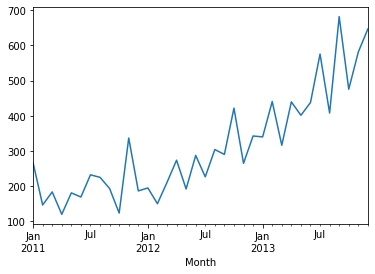

In [4]:
df['Sales'].plot()

- shampoo data 는 seasonality는 보이지 않으나 trend 가 확실히 보이므로 non-stationary.    

- stationary 하게 만들기 위해 differencing 필요. quadratic trend (처음엔 증가세가 완만하다 급격히 증가)가 보임. 따라서 2 차 차분이 필요하다고 보여 d = 2 로 결정.

### seasonal_decompose 함수를 이용하여 seasonality 와 trend 확인

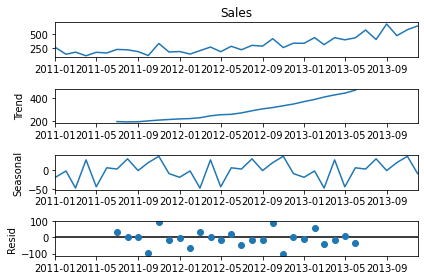

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

decomposition = seasonal_decompose(df['Sales'])

decomposition.plot();

seasonality는 보이지 않으나 Trend는 명확히 존재함을 확인

adf test를 통해 non-stationary 한 시계열임을 확인

In [6]:
def adf_check(ts):
    result = adfuller(ts)
    print('ADF Statistics: {:f}'.format(result[0]))
    print('p-value: {:f} - {}'.format(result[1], 'Non-stationary' if result[1] > 0.05 else 'Stationary'))
    print('Critical Values:')
    for k,v in result[4].items():
        print('\t{}: {:.3f}'.format(k, v))

In [7]:
adf_check(df['Sales'])

ADF Statistics: 3.060142
p-value: 1.000000 - Non-stationary
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


##  ACF/PACF plot

- 시계열 데이터의 성질을 분석하는데 있어서 중요하게 활용되고 있는 것이 상관도표(Correlogram)입니다.   
- 상관도표(Correlogram)는 autocorrelation function(ACF)와 partial autocorrelation function(PACF) 중 하나를 그래프로 표현한 것입니다.   
- 상관도표(Correlogram)를 활용하여 현 시점의 자료와 시점의 차이(lag)를 가지는 자료를 비교하여 어떤 관계를 가지고 있는지를 분석할 수 있습니다. 즉, Correlogram을 활용하여 시점의 차이의 영향력을 알아볼 수 있습니다.  

**자기상관함수(Autocorrelation Fucntion, ACF)**  
- $y_t$와 $y_{t+k}$사이에 correlation을 측정하는 것

**편자기상관함수(Partial Autocorrelation Fucntion, PACF)**  
- PACF는 $y_t$와 $y_{t+k}$와의 correlation을 측정하는 것은 ACF와 동일하나, t와 t+k 사이에 다른 y값들의 영향력을 배제하고 측정하는 것

## Autocorrelation Plot

- parameter p (order of autoregression) 결정을 위해 pandas built-in 기능을 이용하여 autocorrelation 을 plot.

```
 ARIMA(p, d, q)  
    p – lagged observation number (lag order)  
    d – degree of differencing  
    q – window size  
```


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

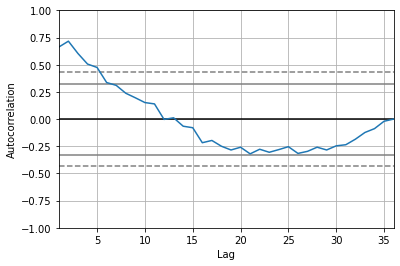

In [8]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Sales'])

- lag 10 이전까지 positive correlation 을 보이고 lag 5 이전까지 확실히 보이므로 p = 5 로 설정.
 (점선이 95% confidence interval을 표시하므로 autocorrelation 이 95% confidence 와 교차하는 lag 5 가 ARIMA model의 p)

## Partial Autocorrelation Plot

ARIMA 의 q 결정

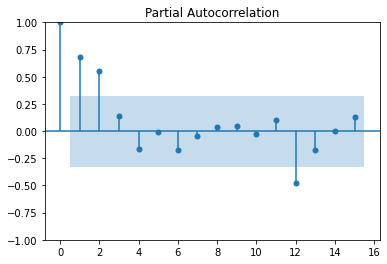

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(df['Sales'], lags=15)
plt.show()

blue area 는 95% confidence interval 표시. lag 0 는 variable 자신이므로 correlation =1.  
lag 2 이후에 confidence interval 아래로 cross 했으므로 ARIMA model의 q = 2 로 정한다.

- statsmodel library 를 이용하여 ARIMA model 생성  
    (1) ARIMA() 호출  
    (2) fit() 함수로 training  
    (3) predict() 함수로 예측  

In [10]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Sales'], order=(5, 2, 2))  # (p,d,q) order
model_fit = model.fit()
model_fit.summary()

C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -191.901
Date:                Sat, 04 Dec 2021   AIC                            399.801
Time:                        08:59:04   BIC                            412.012
Sample:                    01-01-2011   HQIC                           403.966
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2741      3.066     -0.416      0.678      -7.283       4.735
ar.L2         -0.9934      3.912     -0.254      0.800      -8.661       6.674
ar.L3         -0.8128      2.923     -0.278      0.781      -6.542       4.917
ar.L4         -0.5075      2.312     -0.220      0.826      -5.038       4.023
ar.L5         -0.0803      1.328     -0.060      0.952      -2.684       2.523
ma.L1         -0.8519      3.156     -0.270      0.787      -7.037       5.333
ma.L2          0.0832      2.548      0.033      0.974      -4.910       5.077
sigma2      3996.2471   1308.563      3.054      0.002    1431.511    6560.983
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.72   Prob(JB):                         0.81
Heteroskedasticity (H):               0.94   Skew:                            -0.00
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ar.L1 - L5 : 5 variables and coefficient  
ma.L1 - L2 : two moving average variables and coefficient 

model 이 잘 만들어 졌는지 residual 을 이용하여 점검한다.  
residual 에 특별한 pattern이 없고 white noise 이면 Fine.  Pattern 이 보이면 모델 개선 필요.

<AxesSubplot:xlabel='Month'>

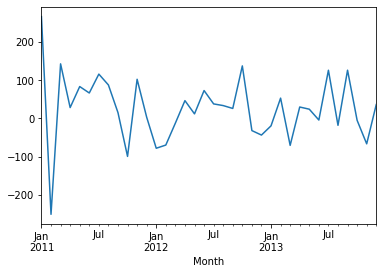

In [11]:
residuals = model_fit.resid

residuals.plot()

trend 나 seasonality 가 보이지 않음.

In [12]:
residuals.describe()

count     36.000000
mean      24.806048
std       88.931498
min     -251.238807
25%      -18.718286
50%       26.920285
75%       75.248607
max      266.000000
dtype: float64

<AxesSubplot:ylabel='Density'>

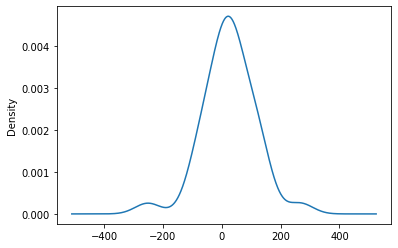

In [13]:
residuals.plot(kind='kde')

mean 과 분산도 looking good.

### Rolling Forecast ARIMA model

- predict() 함수를 이용한 prediction

- 데이터 샘플의 일부인 observation에 대해 예측하는 경우 - in-sample forecast  

- 데이터 샘플의 일부가 아닌 observation에 대해 예측하는 경우 - out-of-sample forecast 입니다.

In [14]:
# train/test split
X = df['Sales'].values
print(X.shape)

train_size = int(X.shape[0] * 0.66)
train, test = X[:train_size], X[train_size:]
print(train.shape)
print(test.shape)

(36,)
(23,)
(13,)


### forecast() 함수는 모델을 사용하여 one-step forecast를 수행합니다.

In [15]:
output = model_fit.forecast()
output

2014-01-01    608.240312
Freq: MS, dtype: float64

predicted=385.809762, expected=342.300000
predicted=328.292787, expected=339.700000
predicted=410.651235, expected=440.400000
predicted=376.596777, expected=315.900000


C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=403.614722, expected=439.300000
predicted=373.077427, expected=401.300000
predicted=464.123851, expected=437.400000


C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=413.291076, expected=575.500000
predicted=458.197736, expected=407.600000
predicted=532.068107, expected=682.000000
predicted=472.674191, expected=475.300000
predicted=683.754234, expected=581.300000
predicted=594.508658, expected=646.900000
Test MSE: 5690.499


C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


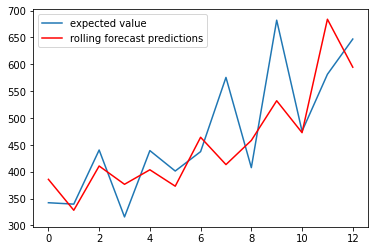

In [16]:
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5, 2, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(yhat)
    
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test, label="expected value")
plt.plot(predictions, color='red', label="rolling forecast predictions")
plt.legend()

In [17]:
model = ARIMA(df['Sales'], order=(5, 2, 2))  # (p,d,q) order
model_fit = model.fit()

forecast = model_fit.forecast(12)
forecast

C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\trimu\Miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


2014-01-01    608.240312
2014-02-01    700.069325
2014-03-01    641.957561
2014-04-01    725.401612
2014-05-01    727.544082
2014-06-01    756.656689
2014-07-01    782.748179
2014-08-01    792.164994
2014-09-01    833.809960
2014-10-01    846.250422
2014-11-01    876.805814
2014-12-01    895.804600
Freq: MS, Name: predicted_mean, dtype: float64

In [18]:
df = pd.concat([df, forecast], axis=1)
df

,Sales,predicted_mean
2011-01-01,266.0,NaN
2011-02-01,145.9,NaN
2011-03-01,183.1,NaN
2011-04-01,119.3,NaN
2011-05-01,180.3,NaN
2011-06-01,168.5,NaN
2011-07-01,231.8,NaN
2011-08-01,224.5,NaN
2011-09-01,192.8,NaN
2011-10-01,122.9,NaN


<AxesSubplot:>

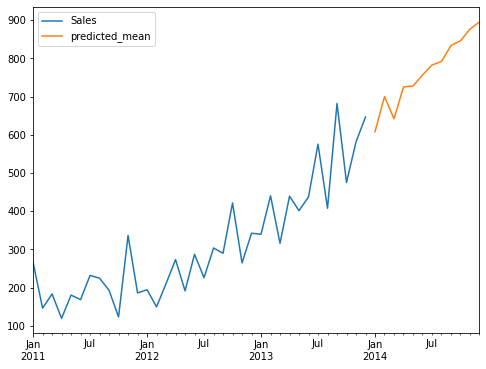

In [19]:
df[['Sales', 'predicted_mean']].plot(figsize=(8, 6))

# SARIMA Model

Seasonal ARIMA : ARIMA(p, d, q)(P, D, Q)m → 7 개 parameter 학습

    - p, d, q : 비계절 요인  
    - P, D, Q : 계절 요인  
    - m : single season period의 timesteps
        
- monthly data 를 가지고 yearly seasonality를 제거하려면 m = 12 로 준다.  
- daily data를 기지고 weekly seasonality를 제거하려면, m= 7으로 준다.

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
df = pd.read_csv("datasets/monthly-milk-production.csv", index_col="Month", parse_dates=True)
df.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


<AxesSubplot:xlabel='Month'>

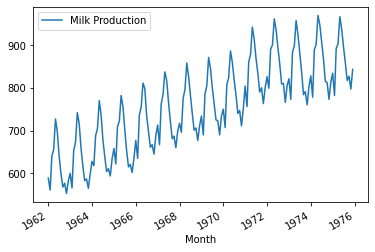

In [22]:
df.plot()

trend 와 seasonality 보임

<AxesSubplot:xlabel='Month'>

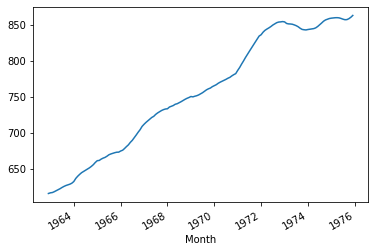

In [23]:
timeseries = df['Milk Production']

timeseries.rolling(12).mean().plot()

평균이 시간에 따라 변하고 있음 --> non-stationary

<AxesSubplot:xlabel='Month'>

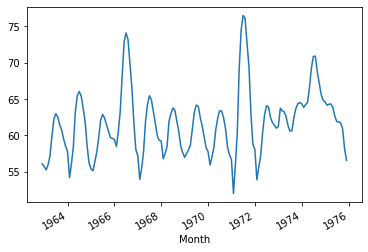

In [24]:
timeseries.rolling(12).std().plot()

variance (std * std) 역시 시간에 따라 fluctuation 이 크므로 non-stationary

### seasonal_decompose 함수를 이용하여 seasonality 와 trend 확인

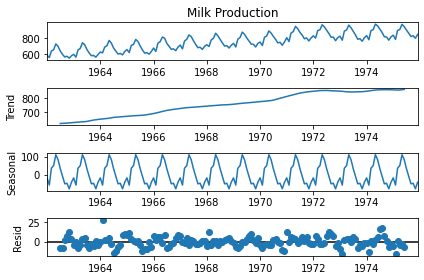

In [25]:
decomposition = seasonal_decompose(timeseries)

decomposition.plot();

**trend 와 yearly seasonality** 가 확인됨

adf test로 non-stationary 한 시계열임을 확인

In [26]:
adf_check(timeseries)

ADF Statistics: -1.303812
p-value: 0.627427 - Non-stationary
Critical Values:
	1%: -3.474
	5%: -2.880
	10%: -2.577


p-value > 0.05 이므로 non-stationary

## Differencing

- trend 제거를 위한 1 차 differencing

In [27]:
df['1st diff'] = df['Milk Production'] - df['Milk Production'].shift(1)
df.head()

,Milk Production,1st diff
Month,,
1962-01-01 01:00:00,589.0,NaN
1962-02-01 01:00:00,561.0,-28.0
1962-03-01 01:00:00,640.0,79.0
1962-04-01 01:00:00,656.0,16.0
1962-05-01 01:00:00,727.0,71.0


In [28]:
adf_check(df['1st diff'].dropna())

ADF Statistics: -3.054996
p-value: 0.030068 - Stationary
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


<AxesSubplot:xlabel='Month'>

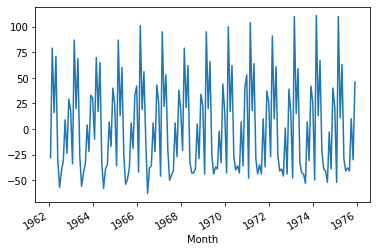

In [29]:
df['1st diff'].plot()

## Seasonal Differencing
- seasonality 제거를 위해 12 개월 shift 로 differencing

<AxesSubplot:xlabel='Month'>

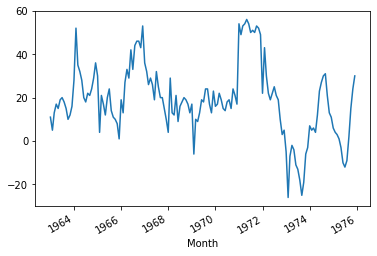

In [30]:
df['seasonal diff'] = df['Milk Production'] - df['Milk Production'].shift(12)
df['seasonal diff'].plot()

In [31]:
adf_check(df['seasonal diff'].dropna())

ADF Statistics: -2.335419
p-value: 0.160799 - Non-stationary
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


- 12 개월 shifting 을 한 차분값도 여전히 non-stationary 하므로 1차 차분값을 이용하여 seasonality 제거.   


- **seasonal differencing method 2** $\rightarrow$ 1st differencing 에 seasonal differencing

<AxesSubplot:xlabel='Month'>

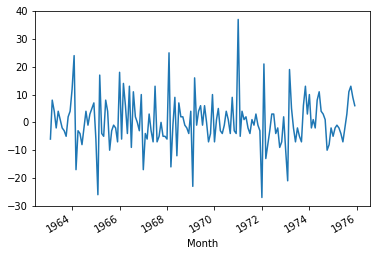

In [32]:
df['seasonal diff2'] = df['1st diff'] - df['1st diff'].shift(12)
df['seasonal diff2'].plot()

In [33]:
adf_check(df['seasonal diff2'].dropna())

ADF Statistics: -5.038002
p-value: 0.000019 - Stationary
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


-  위의 결과에 의해 SARIMA의 I(d, D) parameter 결정 : 

d = 1, D = 1

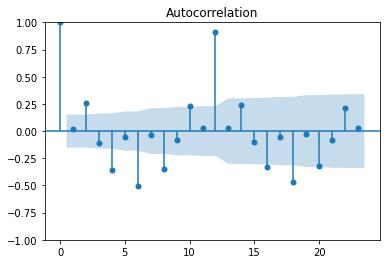

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['1st diff'].dropna());

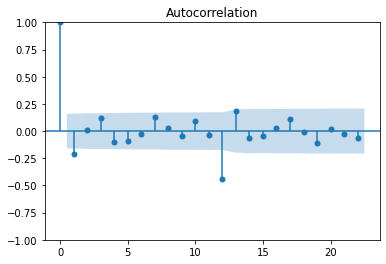

In [35]:
plot_acf(df['seasonal diff2'].dropna());

lag1 에서 confidence interval area 로 들어가므로 p 와 P = 1 로 결정

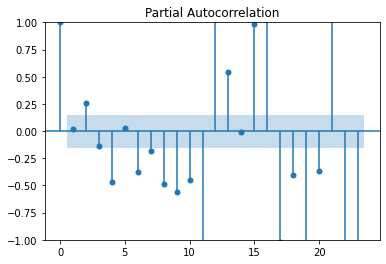

In [36]:
plot_pacf(df['1st diff'].dropna());

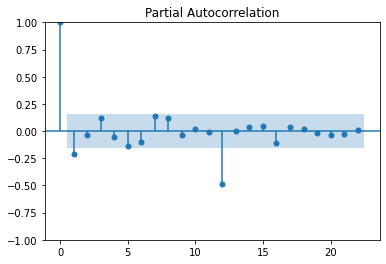

In [37]:
plot_pacf(df['seasonal diff2'].dropna());

lag 1 이후에 confidence interval 아래로 cross 했으므로 ARIMA model의 q, Q = 1 로 정한다.

### 위 결과에 따라 P = 1, Q = 1, p=1, q=1 로 정하여 training 한 후 parameter 개선

(p, d, q) = (1, 1, 1)  
(P, D, Q)m = (1, 1, 1) 12

In [48]:
model = SARIMAX(df['Milk Production'], 
                                  order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Milk Production   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -529.887
Date:                            Sat, 04 Dec 2021   AIC                           1069.775
Time:                                    09:01:53   BIC                           1085.365
Sample:                                01-01-1962   HQIC                          1076.102
                                     - 12-01-1976                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1395      0.337     -0.413      0.679      -0.801       0.522
ma.L1         -0.0942      0.335   

training 중 계산된 residual

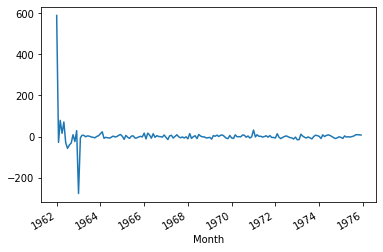

In [39]:
model_fit.resid.plot();

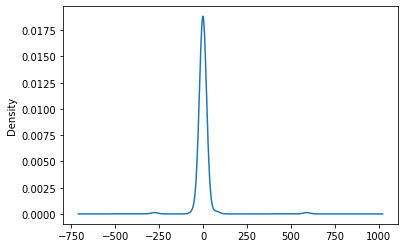

In [40]:
model_fit.resid.plot(kind='kde');

residual 이 평균 0 이고 특별한 pattern 보이지 않음

In [41]:
df.tail()

,Milk Production,1st diff,seasonal diff,seasonal diff2
Month,,,,
1975-08-01 01:00:00,858.0,-38.0,-9.0,3.0
1975-09-01 01:00:00,817.0,-41.0,2.0,11.0
1975-10-01 01:00:00,827.0,10.0,15.0,13.0
1975-11-01 01:00:00,797.0,-30.0,24.0,9.0
1975-12-01 01:00:00,843.0,46.0,30.0,6.0


In [42]:
# in-sample prediction
model_fit.predict()

1962-01-01 01:00:00      0.000000
1962-02-01 01:00:00    588.994692
1962-03-01 01:00:00    561.001245
1962-04-01 01:00:00    639.998403
1962-05-01 01:00:00    655.999934
                          ...    
1975-08-01 01:00:00    855.282822
1975-09-01 01:00:00    808.279023
1975-10-01 01:00:00    817.522958
1975-11-01 01:00:00    788.548825
1975-12-01 01:00:00    835.366295
Freq: MS, Name: predicted_mean, Length: 168, dtype: float64

- out-of-sample prediction : observation 의 next value 예측

In [43]:
# next month
model_fit.forecast()

1976-01-01 01:00:00    865.174111
Freq: MS, dtype: float64

In [44]:
# next 12 months
model_fit.forecast(12)

1976-01-01 01:00:00     865.174111
1976-02-01 01:00:00     818.032984
1976-03-01 01:00:00     925.009745
1976-04-01 01:00:00     938.050293
1976-05-01 01:00:00    1001.299339
1976-06-01 01:00:00     974.036500
1976-07-01 01:00:00     932.842538
1976-08-01 01:00:00     893.109038
1976-09-01 01:00:00     846.670596
1976-10-01 01:00:00     851.436543
1976-11-01 01:00:00     817.054685
1976-12-01 01:00:00     859.204446
Freq: MS, Name: predicted_mean, dtype: float64

In [45]:
forecast = model_fit.forecast(12)
forecast

1976-01-01 01:00:00     865.174111
1976-02-01 01:00:00     818.032984
1976-03-01 01:00:00     925.009745
1976-04-01 01:00:00     938.050293
1976-05-01 01:00:00    1001.299339
1976-06-01 01:00:00     974.036500
1976-07-01 01:00:00     932.842538
1976-08-01 01:00:00     893.109038
1976-09-01 01:00:00     846.670596
1976-10-01 01:00:00     851.436543
1976-11-01 01:00:00     817.054685
1976-12-01 01:00:00     859.204446
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
df = pd.concat([df, forecast], axis=1)

<AxesSubplot:>

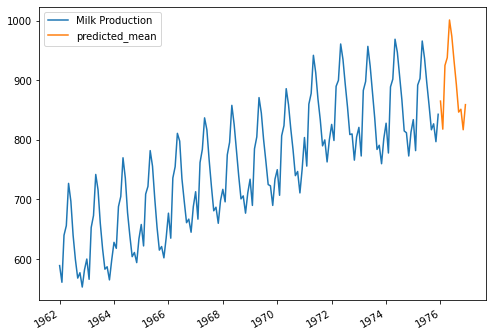

In [47]:
df[['Milk Production', 'predicted_mean']].plot(figsize=(8, 6))